In [151]:
import pandas as pd
import numpy as np

from scipy import stats
from scipy.stats import chi2_contingency

import seaborn as sns

%matplotlib inline


In [152]:
sns.set(
    font_scale = 1, #Размер шрифта
    style      = "whitegrid", # общий вид графиков
    rc         = {'figure.figsize':(12,6)} # размер фигуры
)


In [153]:
users = pd.read_csv('/Users/georgiisilakov/DataspellProjects/AB_tests/Delivered/ab_users_data.csv') #загружаем датасет с пользователями


In [154]:
orders = pd.read_csv('/Users/georgiisilakov/DataspellProjects/AB_tests/Delivered/ab_orders.csv') #загружаем датасет с заказами


In [155]:
orders.head()


,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56.000000,"{74, 6}"
4,1259,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"


In [156]:
orders['product_ids'] = orders['product_ids'].apply(lambda x: x.strip("{}")) # Убраем фигурные скобки


In [157]:
orders['product_ids'] = orders['product_ids'].apply(lambda x: x.split(",")) # Разделяем элементы по ","


In [158]:
orders = orders.explode('product_ids')
#Используем explode, чтобы преобразовать каждый элемент в списке в строку


In [159]:
orders = orders.rename(columns = {'product_ids' : 'product_id'})
orders.product_id = orders.product_id.astype(int)
#Переименовываем колонку и меняем формат на числовой для соединения с датасетом products


In [160]:
products = pd.read_csv('/Users/georgiisilakov/DataspellProjects/AB_tests/Delivered/ab_products.csv') #загружаем датасет с информацией о продуктах


In [161]:
products.product_id = products.product_id.astype('int')
#В products также меняем формат для объединения с orders


In [162]:
ord_prod = orders.merge(products, how = 'left', on = 'product_id') #Соединяем датасеты


In [163]:
ord_prod.head()


,order_id,creation_time,product_id,name,price
0,1255,2022-08-26 00:00:19.000000,75,сок ананасовый,120.0
1,1255,2022-08-26 00:00:19.000000,22,сок мультифрукт,120.0
2,1255,2022-08-26 00:00:19.000000,53,мука,78.3
3,1255,2022-08-26 00:00:19.000000,84,мандарины,90.4
4,1256,2022-08-26 00:02:21.000000,56,сосиски,150.0


In [164]:
user_order_prod = users.merge(ord_prod, how = 'left', on = 'order_id')
#Объединяем полученый датасет с датасетом с информацией о пользователях


In [165]:
user_order_prod.head()


,user_id,order_id,action,time,date,group,creation_time,product_id,name,price
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,75,сок ананасовый,120.0
1,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,22,сок мультифрукт,120.0
2,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,53,мука,78.3
3,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,84,мандарины,90.4
4,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,2022-08-26 00:02:21.000000,56,сосиски,150.0


### Посмотрим как изменилось общее число заказов:

In [166]:
users.head()


,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1


Посмотрим на временой период в двух группах

In [167]:
users[users['group'] == 0].time.min(),users[users['group'] == 0].time.max()


('2022-08-26 00:00:19.000000', '2022-09-08 23:41:24.000000')

In [168]:
users[users['group'] == 1].time.min(),users[users['group'] == 1].time.max()


('2022-08-26 00:02:21.000000', '2022-09-08 23:18:05.000000')

Даты первой и последней покупки в обеих группах совпадают, это значит, что анализируемый период одинаков для обеих групп, поэтому можем просто сравнить активность двух групп по количеству ордеров

In [169]:
df_orders = users.groupby(['group','action'], as_index = False).agg({'order_id' : 'count'}) \
    .pivot(index = 'group' , columns = 'action' , values = 'order_id').reset_index()


In [170]:
df_orders = df_orders.assign(cancel_percent = df_orders.cancel_order / df_orders.create_order * 100).round(2)
df_orders


action,group,cancel_order,create_order,cancel_percent
0,0,82,1609,5.10
1,1,132,2514,5.25


### Вывод:
Как видно из таблицы выше количество созданных ордеров в группе 1, где работала новая система рекомендаций выше, чем в группе 0 на 905 ордеров или 56%. В то же время % отмененных ордеров практически на том же уровне - порядка 5%.
Из этого можно сделать вывод, что новая система рекомендаций товаров положительно влияет на желание пользователей оформлять заказ, в то же время не увеличивая удельный вес отмененных ордеров.

### Сравним частоту возвращения пользователей в наше приложение:

### Гипотеза: оказала ли новая система рекомендаций статистически значимое влияние на возвращение пользователей в приложение(retention)

- H0 - частота возвращения пользователей группы 0 и группы 1 в наше приложение не отличается статистически значимо
- H1 - частота возвращения пользователей группы 0 и группы 1 в наше приложение отличается статистически значимо

In [171]:
users.time = pd.to_datetime(users.time) #Переведем в формат datetime для работы со временем


In [172]:
users.time = users.time.dt.strftime('%Y-%m-%d')


In [173]:
users['first_buy'] = users.groupby('user_id')['time'].transform('min')
#запишем в колонку first_buy минмальную дату покупки по пользователям


In [174]:
users['retention'] = (users.time == users.first_buy)
users['retention'] = (-users['retention']).astype(np.int8)
# Если минимальная дата покупки отличается от актуальной - значит пользователь сделал заказ вновь - 1 в retention


In [175]:
users


,user_id,order_id,action,time,date,group,first_buy,retention
0,964,1255,create_order,2022-08-26,2022-08-26,0,2022-08-26,0
1,965,1256,create_order,2022-08-26,2022-08-26,1,2022-08-26,0
2,964,1257,create_order,2022-08-26,2022-08-26,0,2022-08-26,0
3,966,1258,create_order,2022-08-26,2022-08-26,0,2022-08-26,0
4,967,1259,create_order,2022-08-26,2022-08-26,1,2022-08-26,0
...,...,...,...,...,...,...,...,...
4332,990,59422,create_order,2022-09-08,2022-09-08,1,2022-08-26,1
4333,1418,59439,create_order,2022-09-08,2022-09-08,1,2022-08-26,1
4334,1605,59464,create_order,2022-09-08,2022-09-08,0,2022-08-26,1
4335,1461,59487,create_order,2022-09-08,2022-09-08,0,2022-08-26,1


In [176]:
pd.crosstab(users.group, users.retention).reset_index().rename(columns = {0 : 'не вернулся', 1 : 'вернулся'})


retention,group,не вернулся,вернулся
0,0,661,1030
1,1,723,1923


Как видно из таблицы в группе 1 пользователи возвращаются в приложение значительно чаще

In [177]:
pd.crosstab(users.group, users.retention)
df_ret = pd.crosstab(users.group, users.retention)
table = np.array(df_ret)
res = chi2_contingency(table)
print('statistic =', res[0], 'p-value =', res[1])


statistic = 65.18147790764827 p-value = 6.830855428403218e-16


### Вывод:
Критерий хи-квадрат показал, что показатель статистики выше критических значений, а также значение p-value меньше 0.05. Это означает, что мы должны принять альтернативную гипотезу, о том, что частота возвращения пользователей отличается между группами статистически значимо.

### Сравним средний чек пользователей по группам:

### Гипотеза: оказала ли новая система рекомендаций статистически значимое влияние на средний чек пользователей

- H0 - значения среднего чека в группах не отличаются статистически значимо
- H1 - значения среднего чека в группах отличаются статистически значимо

In [178]:
avg_check_group0 = user_order_prod.query('group == 0 and action == "create_order"').groupby(['user_id', 'order_id'], as_index = False).agg({'price' : 'sum'}) \
    .groupby('user_id',as_index = False).agg({'price' : 'mean'})


<Axes: xlabel='price', ylabel='Count'>

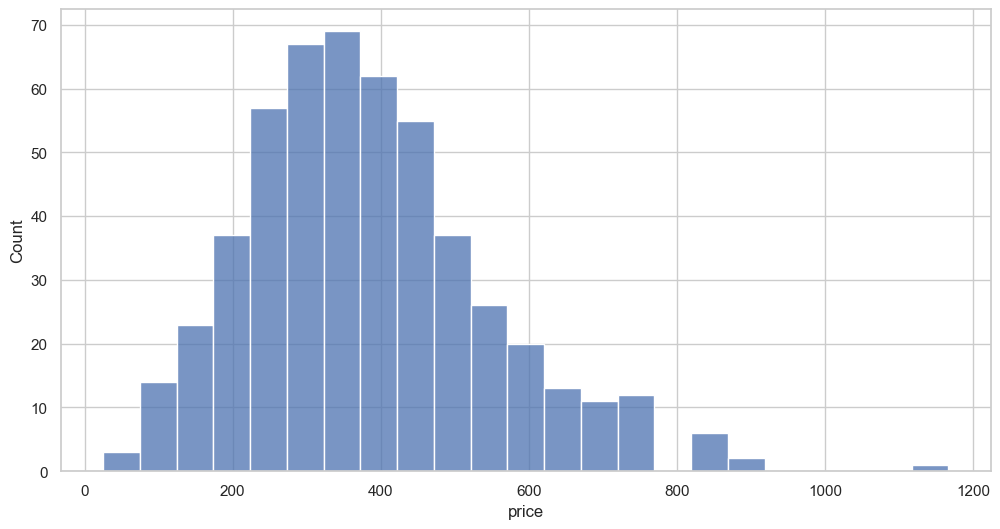

In [179]:
sns.histplot(avg_check_group0.price)


In [180]:
avg_check_group1 = user_order_prod.query('group == 1 and action == "create_order"').groupby(['user_id', 'order_id'], as_index = False).agg({'price' : 'sum'}) \
    .groupby('user_id',as_index = False).agg({'price' : 'mean'})


<Axes: xlabel='price', ylabel='Count'>

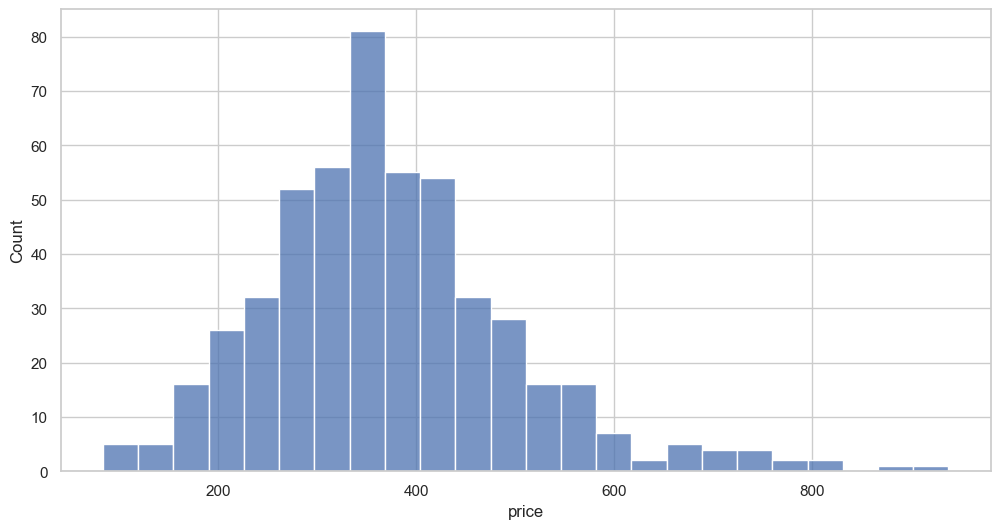

In [181]:
sns.histplot(avg_check_group1.price)


Как видно на графиках и в группе 0 и группе 1 распределение среднего чека близко к нормальному, но с очевидными выбросами 

In [182]:
stats.shapiro(avg_check_group0.price)


ShapiroResult(statistic=0.9676898121833801, pvalue=3.1785560850039474e-09)

In [183]:
stats.shapiro(avg_check_group1.price)


ShapiroResult(statistic=0.9591402411460876, pvalue=1.4001211301462035e-10)

Согласно тесту Шапиро-Уилка, в обеих группах средний чек имеет нормальное распределение, поэтому для сравнения средних значений я буду использовать Т-критерий.

In [184]:
stats.ttest_ind(avg_check_group0.price, avg_check_group1.price)


Ttest_indResult(statistic=1.1434040168228712, pvalue=0.25314048853143994)

### Вывод: 
Значение p-value больше 0.05, поэтому принимаю нулевую гипотезу о том, что средний чек статистически значимо не отличается. Новая система рекомендаций не оказала значимого влияние на средний чек

### Общий вывод:
Новая система рекомендаций определенно принесла пользу бизнесу, так как виден значительный рост заказов пользователей и также оказала влияние на желание пользователей возвращаться в наше приложение для повторных заказов. На средний чек в свою очередь значимого влияния система рекомендаций не оказала. 
Исходя из полученных результатов новую систему рекомендаций необходимо активировать для всех пользователей сервиса, так как увеличение числа заказов и желание пользователей возвращаться в наше приложение напрямую отразится в росте выручки компании.
